## Importing librariesl

In [1]:
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# pd.set_option('max_columns', 200)

## Load training data

In [2]:
data = []
with open('data/KDDTrain+.arff', "r") as f:
    for line in f:
        line = line.replace('\n', '')
        data.append(line.split(','))


names = ['duration',  'protocol_type', 'service',  'flag',  'src_bytes' , 'dst_bytes' , 'land' , 'wrong_fragment' , 'urgent' , 'hot' , 'num_failed_logins' ,
 'logged_in' , 'num_compromised' , 'root_shell' , 'su_attempted' , 'num_root' , 'num_file_creations' , 'num_shells' , 'num_access_files' , 'num_outbound_cmds' ,
 'is_host_login' , 'is_guest_login' , 'count' , 'srv_count' , 'serror_rate' , 'srv_serror_rate' , 'rerror_rate' , 'srv_rerror_rate' , 'same_srv_rate' ,
 'diff_srv_rate' , 'srv_diff_host_rate' , 'dst_host_count' , 'dst_host_srv_count' , 'dst_host_same_srv_rate' , 'dst_host_diff_srv_rate' , 'dst_host_same_src_port_rate' ,
 'dst_host_srv_diff_host_rate' , 'dst_host_serror_rate', 'dst_host_srv_serror_rate' , 'dst_host_rerror_rate' , 'dst_host_srv_rerror_rate' , 'class' ,]
    
df = pd.DataFrame(data[44:], columns=names)

In [3]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
df.shape

(125973, 42)

In [5]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,25,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
125969,8,udp,private,SF,105,145,0,0,0,0,...,244,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,30,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,8,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [6]:
df.dtypes

duration                       object
protocol_type                  object
service                        object
flag                           object
src_bytes                      object
dst_bytes                      object
land                           object
wrong_fragment                 object
urgent                         object
hot                            object
num_failed_logins              object
logged_in                      object
num_compromised                object
root_shell                     object
su_attempted                   object
num_root                       object
num_file_creations             object
num_shells                     object
num_access_files               object
num_outbound_cmds              object
is_host_login                  object
is_guest_login                 object
count                          object
srv_count                      object
serror_rate                    object
srv_serror_rate                object
rerror_rate 

In [7]:
# Define the expected data types based on the research paper
expected_data_types = {
    'duration': 'float64',
    'protocol_type': 'category',
    'service': 'category',
    'flag': 'category',
    'src_bytes': 'float64',
    'dst_bytes': 'float64',
    'land': 'category',
    'wrong_fragment': 'float64',
    'urgent': 'float64',
    'hot': 'float64',
    'num_failed_logins': 'float64',
    'logged_in': 'category',
    'num_compromised': 'float64',
    'root_shell': 'float64',
    'su_attempted': 'float64',
    'num_root': 'float64',
    'num_file_creations': 'float64',
    'num_shells': 'float64',
    'num_access_files': 'float64',
    'num_outbound_cmds': 'float64',
    'is_host_login': 'category',
    'is_guest_login': 'category',
    'count': 'float64',
    'srv_count': 'float64',
    'serror_rate': 'float64',
    'srv_serror_rate': 'float64',
    'rerror_rate': 'float64',
    'srv_rerror_rate': 'float64',
    'same_srv_rate': 'float64',
    'diff_srv_rate': 'float64',
    'srv_diff_host_rate': 'float64',
    'dst_host_count': 'float64',
    'dst_host_srv_count': 'float64',
    'dst_host_same_srv_rate': 'float64',
    'dst_host_diff_srv_rate': 'float64',
    'dst_host_same_src_port_rate': 'float64',
    'dst_host_srv_diff_host_rate': 'float64',
    'dst_host_serror_rate': 'float64',
    'dst_host_srv_serror_rate': 'float64',
    'dst_host_rerror_rate': 'float64',
    'dst_host_srv_rerror_rate': 'float64',
    'class': 'category'
}

# Convert columns to appropriate data types
df = df.astype(expected_data_types)


In [8]:
df.dtypes

duration                        float64
protocol_type                  category
service                        category
flag                           category
src_bytes                       float64
dst_bytes                       float64
land                           category
wrong_fragment                  float64
urgent                          float64
hot                             float64
num_failed_logins               float64
logged_in                      category
num_compromised                 float64
root_shell                      float64
su_attempted                    float64
num_root                        float64
num_file_creations              float64
num_shells                      float64
num_access_files                float64
num_outbound_cmds               float64
is_host_login                  category
is_guest_login                 category
count                           float64
srv_count                       float64
serror_rate                     float64


In [9]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [10]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [11]:
X = df.drop(["class"],axis = 1)

In [12]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Encoding Categorical Data

In [13]:
# Protocol type
X['protocol_type'] = df['protocol_type'].astype('category').cat.codes

# Land
X['land'] = pd.Categorical(df['land'], ['0', '1']).codes

# Is logged in
X['logged_in'] = pd.Categorical(df['logged_in'], ['0', '1']).codes

# Host logged in
X['is_host_login'] = pd.Categorical(df['is_host_login'], ['0', '1']).codes

# Guest logged in
X['is_guest_login'] = pd.Categorical(df['is_guest_login'], ['0', '1']).codes

# Class
Y = pd.Categorical(df['class'], ['normal', 'anomaly']).codes


In [14]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,2,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
from sklearn.preprocessing import LabelEncoder

le_service = LabelEncoder()
X['service'] = le_service.fit_transform(df['service'])

le_flag = LabelEncoder()
X['flag'] = le_flag.fit_transform(df['flag'])



In [16]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,tcp,ftp_data,SF,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0.0,udp,other,SF,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0.0,tcp,private,S0,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0.0,tcp,http,SF,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0.0,tcp,http,SF,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [17]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,1,20,9,491.0,0.0,0,0.0,0.0,0.0,...,150.0,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0.0,2,44,9,146.0,0.0,0,0.0,0.0,0.0,...,255.0,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0.0,1,49,5,0.0,0.0,0,0.0,0.0,0.0,...,255.0,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0.0,1,24,9,232.0,8153.0,0,0.0,0.0,0.0,...,30.0,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0.0,1,24,9,199.0,420.0,0,0.0,0.0,0.0,...,255.0,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Data Visualization

In [18]:
# Descriptive statistics for numerical columns
numerical_summary = X.describe()

# Distribution of protocol_type
categorical_distribution_protocol = X['protocol_type'].value_counts()

# Display the results
print("Descriptive Statistics for Numerical Columns:")
print(numerical_summary)

print("\nDistribution of 'protocol_type' (Categorical Variable):")
print(categorical_distribution_protocol)

# Distribution of service
categorical_distribution_service = X['service'].value_counts()
print("\nDistribution of 'service' (Categorical Variable):")
print(categorical_distribution_service)

# Distribution of flag
categorical_distribution_flag = X['flag'].value_counts()
print("\nDistribution of 'flag' (Categorical Variable):")
print(categorical_distribution_flag)

# Distribution of land
categorical_distribution_land = X['land'].value_counts()
print("\nDistribution of 'land' (Categorical Variable):")
print(categorical_distribution_land)

# Distribution of logged_in
categorical_distribution_login = X['logged_in'].value_counts()
print("\nDistribution of 'logged_in' (Categorical Variable):")
print(categorical_distribution_login)

# Distribution of is_host_login
categorical_distribution_is_host_login = X['is_host_login'].value_counts()
print("\nDistribution of 'is_host_login' (Categorical Variable):")
print(categorical_distribution_is_host_login)


# Distribution of is_guest_login
categorical_distribution_is_guest_login = X['is_guest_login'].value_counts()
print("\nDistribution of 'is_guest_login' (Categorical Variable):")
print(categorical_distribution_is_guest_login)

# # Distribution of class
# Y = Y.value_counts()
# print("\nDistribution of 'class' (Categorical Variable):")
# print(Y)


Descriptive Statistics for Numerical Columns:
           duration  protocol_type        service           flag  \
count  125973.00000  125973.000000  125973.000000  125973.000000   
mean      287.14465       1.053202      31.226469       6.979996   
std      2604.51531       0.426620      16.346470       2.689365   
min         0.00000       0.000000       0.000000       0.000000   
25%         0.00000       1.000000      20.000000       5.000000   
50%         0.00000       1.000000      24.000000       9.000000   
75%         0.00000       1.000000      49.000000       9.000000   
max     42908.00000       2.000000      69.000000      10.000000   

          src_bytes     dst_bytes           land  wrong_fragment  \
count  1.259730e+05  1.259730e+05  125973.000000   125973.000000   
mean   4.556674e+04  1.977911e+04       0.000198        0.022687   
std    5.870331e+06  4.021269e+06       0.014086        0.253530   
min    0.000000e+00  0.000000e+00       0.000000        0.000000   
2

In [19]:
numerical_summary

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.00000,125973.000000,125973.000000,125973.000000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,1.053202,31.226469,6.979996,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,...,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240
std,2604.51531,0.426620,16.346470,2.689365,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,...,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459
min,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,1.000000,20.000000,5.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,1.000000,24.000000,9.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,1.000000,49.000000,9.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42908.00000,2.000000,69.000000,10.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
X.dtypes

duration                       float64
protocol_type                     int8
service                          int32
flag                             int32
src_bytes                      float64
dst_bytes                      float64
land                              int8
wrong_fragment                 float64
urgent                         float64
hot                            float64
num_failed_logins              float64
logged_in                         int8
num_compromised                float64
root_shell                     float64
su_attempted                   float64
num_root                       float64
num_file_creations             float64
num_shells                     float64
num_access_files               float64
num_outbound_cmds              float64
is_host_login                     int8
is_guest_login                    int8
count                          float64
srv_count                      float64
serror_rate                    float64
srv_serror_rate          

In [21]:
type(Y)

numpy.ndarray

In [22]:

# Specify the columns to be standardized
columns_to_standardize = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
                           'num_compromised', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
                           'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
                           'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
                           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
                           'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
                           'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the specified columns
X[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])


In [23]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,-0.110249,1,20,9,-0.007679,-0.004919,0,-0.089486,-0.007736,-0.095076,...,-0.324063,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387
1,-0.110249,2,44,9,-0.007737,-0.004919,0,-0.089486,-0.007736,-0.095076,...,0.734343,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387
2,-0.110249,1,49,5,-0.007762,-0.004919,0,-0.089486,-0.007736,-0.095076,...,0.734343,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387
3,-0.110249,1,24,9,-0.007723,-0.002891,0,-0.089486,-0.007736,-0.095076,...,-1.533670,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084
4,-0.110249,1,24,9,-0.007728,-0.004814,0,-0.089486,-0.007736,-0.095076,...,0.734343,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387


C:\Users\Rakin Shahriar\anaconda3\envs\APT\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Rakin Shahriar\anaconda3\envs\APT\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


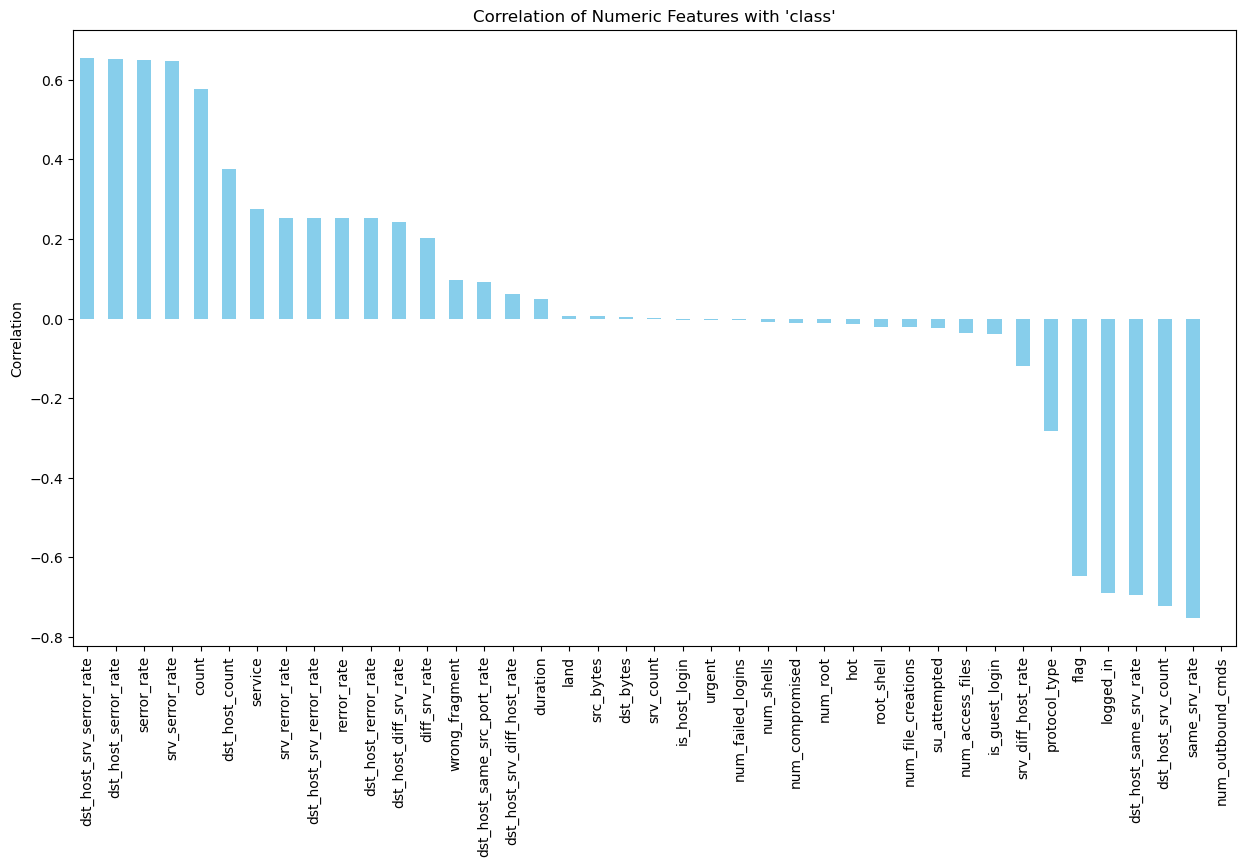

In [24]:
# Plot correlation of numeric features with the target variable
Y_series = pd.Series(Y, index=X.index)
plt.figure(figsize=(15, 8))
df_corr_with_class = X.corrwith(Y_series).sort_values(ascending=False)
df_corr_with_class.plot(kind='bar', color='skyblue')
plt.title("Correlation of Numeric Features with 'class'")
plt.ylabel("Correlation")
plt.show()

### Feature Extraction With PCA

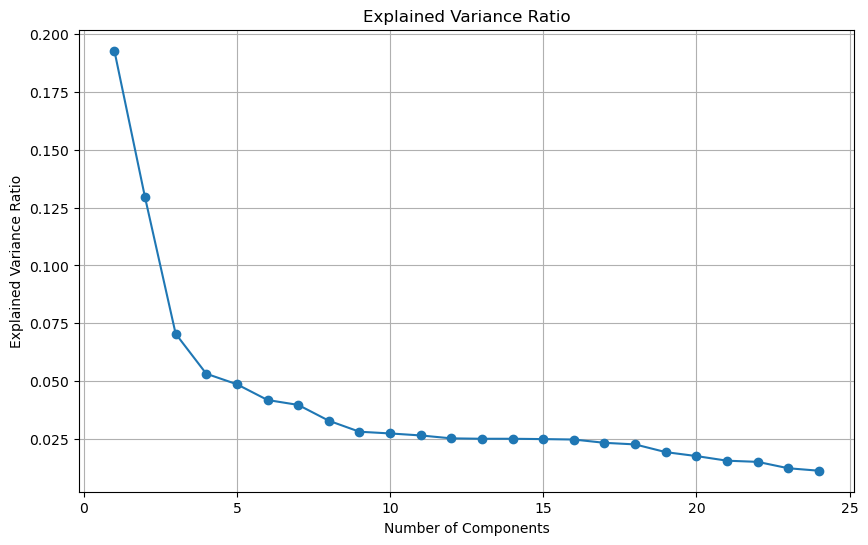

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()


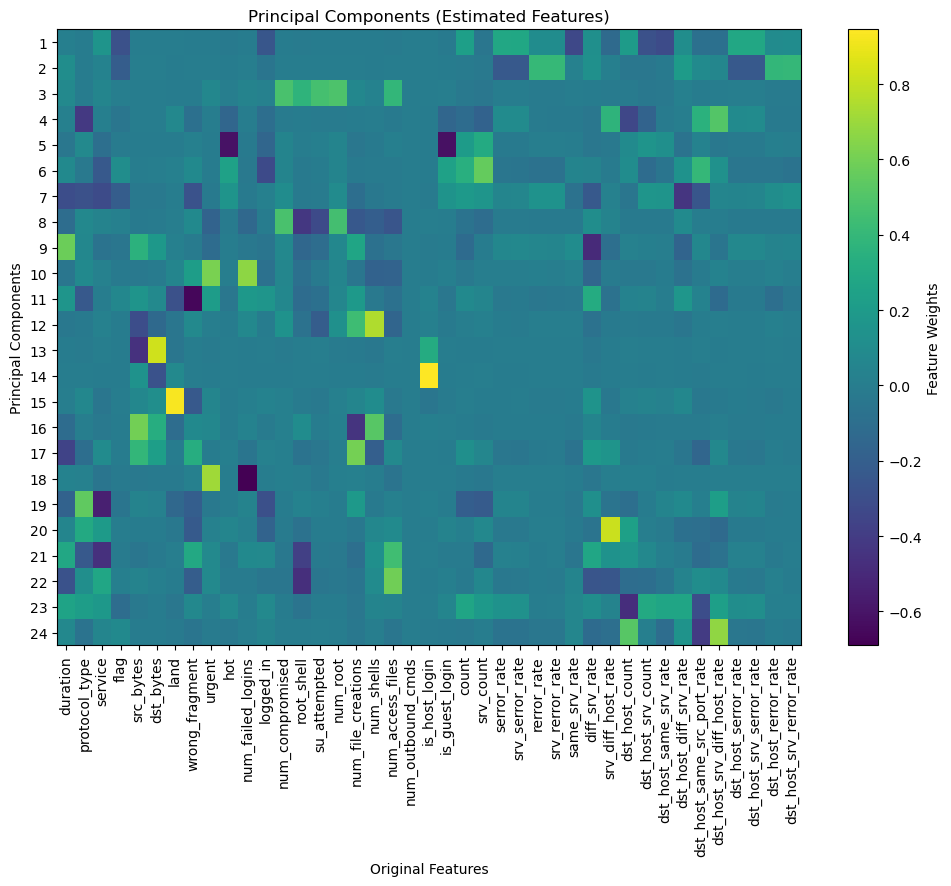

In [26]:
import numpy as np

# Get the principal components
principal_components = pca.components_

# Create a DataFrame to display the principal components
components_df = pd.DataFrame(principal_components, columns=X.columns)

# Visualize the components
plt.figure(figsize=(12, 8))
plt.imshow(components_df, cmap='viridis', aspect='auto')
plt.colorbar(label='Feature Weights')
plt.xticks(range(len(X.columns)), X.columns, rotation=90)
plt.yticks(range(len(pca.components_)), range(1, len(pca.components_) + 1))
plt.title('Principal Components (Estimated Features)')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()


In [27]:
import pandas as pd

# Number of components
num_components = pca.n_components_

# Variance explained by each component
explained_variance_ratio = pca.explained_variance_ratio_

# DataFrame of principal components
df_pca = pd.DataFrame(data=X_pca, columns=[f"PC{i+1}" for i in range(num_components)])

# Convert Y to a pandas Series
series_y = pd.Series(Y, name='target')

# Concatenate principal components with target variable
df_final = pd.concat([df_pca, series_y], axis=1)



In [28]:
df_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,target
0,-0.983117,-0.109606,-0.036897,0.033465,-0.132767,0.296035,-0.532039,0.108988,0.136264,0.098300,...,0.053772,-0.268240,0.014280,0.502045,-0.337406,-0.097749,0.304569,-1.424525,-0.029863,0
1,0.587595,0.714602,0.085894,-0.423715,-0.211797,1.349924,-3.773742,0.749218,-0.760440,-0.122385,...,0.055509,-0.554174,0.000353,1.299164,0.429725,-1.110560,0.976161,-1.220824,-0.236806,0
2,3.627381,-2.008158,0.049744,0.341988,-0.169052,-0.504041,-0.039986,0.021583,0.163078,0.045756,...,-0.016442,-0.055882,0.000144,-0.208736,0.131679,-0.233604,0.128488,0.074524,0.023857,1
3,-2.629608,-0.622210,-0.066070,-0.018988,-0.048444,-1.057739,0.371439,0.045164,0.060498,-0.050476,...,0.015709,-0.099221,0.023314,0.069053,-0.920580,-0.001004,0.033162,0.819046,-0.394915,0
4,-2.418554,-0.538466,-0.122079,-1.067483,0.332892,-0.574313,0.327768,-0.018408,0.016560,-0.144816,...,-0.062425,-0.005020,0.025409,-0.414130,0.006964,0.372579,-0.280922,-0.310199,0.619964,0


In [29]:
df_pca.columns

Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19',
       'PC20', 'PC21', 'PC22', 'PC23', 'PC24'],
      dtype='object')

### Building Model with AutoEncoder

In [30]:
X_train = df_pca

In [31]:
Y_train = series_y

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# Define your autoencoder architecture
def build_autoencoder(input_shape):
    input_layer = layers.Input(shape=input_shape)
    # Encoder
    encoder = layers.Dense(128, activation='relu')(input_layer)
    encoder = layers.Dense(64, activation='relu')(encoder)
    encoder = layers.Dense(32, activation='relu')(encoder)
    # Decoder
    decoder = layers.Dense(64, activation='relu')(encoder)
    decoder = layers.Dense(128, activation='relu')(decoder)
    decoder = layers.Dense(input_shape[0], activation='sigmoid')(decoder)
    # Autoencoder model
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train the autoencoder
def train_autoencoder(autoencoder, X_train, epochs, batch_size):
    autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, shuffle=True)

# Reconstruction error calculation
def calculate_reconstruction_error(autoencoder, X):
    reconstructions = autoencoder.predict(X)
    errors = np.mean(np.square(X - reconstructions), axis=1)
    return errors

# Anomaly detection using reconstruction error
def detect_anomalies(reconstruction_errors, threshold):
    anomalies = reconstruction_errors > threshold
    return anomalies

# Example usage
if __name__ == "__main__":
    # Load your dataset (X_train, X_test, Y_train, Y_test)
    # Preprocess your data if needed
    # Build and train the autoencoder
    input_shape = (41,) 
    autoencoder = build_autoencoder(input_shape)
    train_autoencoder(autoencoder, X, epochs=20, batch_size=20)
    
    # Calculate reconstruction errors for test data
    test_errors = calculate_reconstruction_error(autoencoder, X)
    # Determine threshold (e.g., using percentile of errors)
    threshold = np.percentile(test_errors, 95)  # Example threshold
    # Detect anomalies
    anomalies = detect_anomalies(test_errors, threshold)
    # Evaluate performance (e.g., using precision, recall, F1-score)
    # Further analysis and visualization as needed
    


Epoch 1/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 30.3923
Epoch 2/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.4206
Epoch 3/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.4321
Epoch 4/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 30.2882
Epoch 5/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.3189
Epoch 6/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.7148
Epoch 7/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 30.3639
Epoch 8/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 30.4081
Epoch 9/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 30.2169
Epoch 10/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 30.1507
Epoch 11/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 30.3082
Epoch 12/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.6183
Epoch 13/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 30.3047
Epoch 14/20
6299/6299 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - loss: 30.3192
E

### Evaluation

3937/3937 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


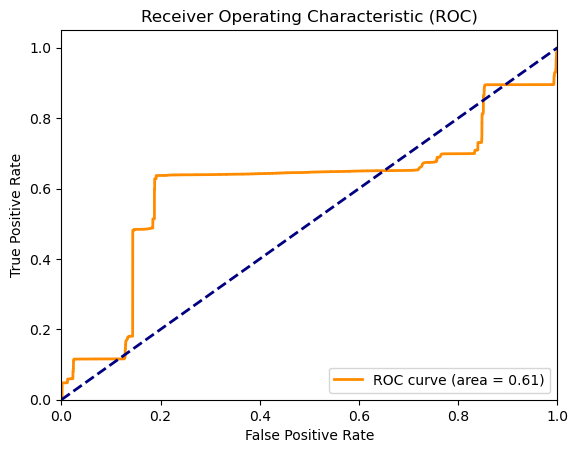

AUC-ROC: 0.6053832711167042


In [33]:
from sklearn.metrics import roc_curve, auc

# Compute reconstruction errors
reconstruction_errors = autoencoder.predict(X) - X
reconstruction_errors = np.linalg.norm(reconstruction_errors, axis=1)

# Define true labels (0 for normal instances, 1 for anomalous instances)
true_labels = Y_train  # Replace with your true labels

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC-ROC:", roc_auc)
